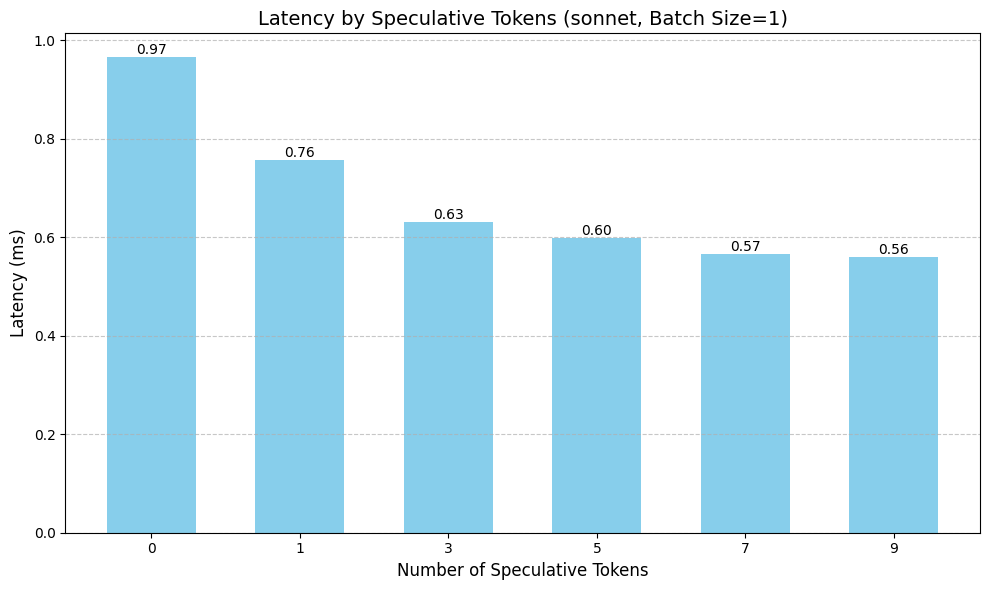

In [1]:
import matplotlib.pyplot as plt
import json

num_speculative_tokens_list = [0, 1, 3, 5, 7, 9]
dataset_name = "sonnet"

batch_size = 1
latencies = {
    nt: json.load(open(f"results/{dataset_name}_batch-size-{batch_size}_ntokens-{nt}.json"))["percentiles"]["50"]
    for nt in num_speculative_tokens_list
}
x_labels = [str(nt) for nt in latencies]  # 将数值转为字符串标签
x_positions = range(len(x_labels))  # 生成均匀分布的 x 坐标

plt.figure(figsize=(10, 6))
bars = plt.bar(x_positions, latencies.values(), width=0.6, color='skyblue')

# 添加数值标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.xlabel("Number of Speculative Tokens", fontsize=12)
plt.ylabel("Latency (ms)", fontsize=12)
plt.title(f"Latency by Speculative Tokens ({dataset_name}, Batch Size={batch_size})", fontsize=14)
plt.xticks(x_positions, x_labels)  # 关键：用字符串标签替代数值坐标
plt.grid(axis='y', linestyle='--', alpha=0.7)  # 添加横向网格线

plt.tight_layout()  # 自动调整布局
plt.show()

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

def get_y_data(entry, label):
    if label == "overhead":
        t = entry['forward_start_time'] - entry['start_time']
    elif label == "verify_time":
        t = entry['forward_end_time'] - entry['forward_start_time']
    elif label == "propose_time":
        t = entry['propose_end_time'] - entry['propose_start_time']
    elif label == "rejection_sampling":
        t = entry['propose_start_time'] - entry['forward_end_time']
    return t * 1000
   
def get_rej_ratio(entry):
    return ((entry['propose_start_time'] - entry['forward_end_time']) / \
              (entry['end_time'] - entry['start_time'])) * 100

def get_propose_ratio(entry):
    return ((entry['propose_end_time'] - entry['propose_start_time']) / \
              (entry['end_time'] - entry['start_time'])) * 100
def get_verify_ratio(entry):
    return ((entry['forward_end_time'] - entry['forward_start_time']) / \
              (entry['end_time'] - entry['start_time'])) * 100

# 1. Load data
y_label = "verify_time"
data = []
with open('profiler_data.jsonl') as f: 
    for line in f:
        entry = json.loads(line)
        data.append({
            y_label: get_y_data(entry, y_label),
            'num_kv_tokens': entry['num_kv_tokens'],
            'num_compute_tokens': entry['num_compute_tokens'],
            'batch_size': entry['batch_size'],
            'enable_spec_decode': entry['num_compute_tokens'] != entry['batch_size'],
            'rej_ratio': get_rej_ratio(entry),
            'propose_ratio': get_propose_ratio(entry),
            'verify_ratio': get_verify_ratio(entry),
        })

df = pd.DataFrame(data)
df 



,verify_time,num_kv_tokens,num_compute_tokens,batch_size,enable_spec_decode,rej_ratio,propose_ratio,verify_ratio
0,22.189379,13,13,1,True,4.677491,0.447262,89.518689
1,22.057533,13,13,1,True,4.874455,0.422819,89.105917
2,24.054289,13,13,1,True,4.508639,0.388173,89.209861
3,24.025440,13,13,1,True,4.674210,0.393051,89.006068
4,18.474817,14,1,1,False,4.437842,0.527023,91.361300
...,...,...,...,...,...,...,...,...
367135,18.074274,21,1,1,False,3.314262,0.756742,92.678305
367136,18.178225,22,1,1,False,3.264428,0.700044,93.149831
367137,18.189907,22,1,1,False,3.279169,0.748373,93.142557
367138,18.137932,22,1,1,False,3.357285,0.762465,92.808432


(0.0, 100.0)

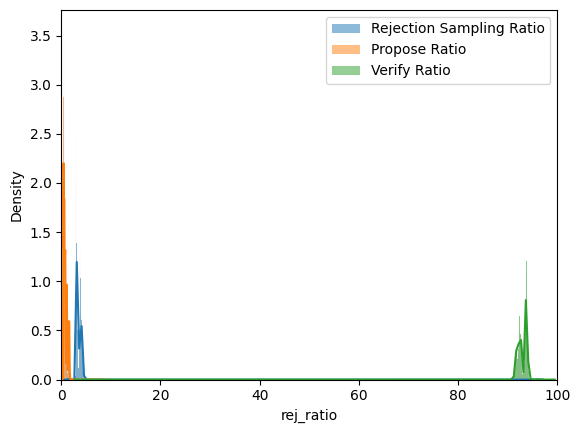

In [33]:
import seaborn as sns
sns.histplot(df['rej_ratio'], kde=True, stat="density", label='Rejection Sampling Ratio')
sns.histplot(df['propose_ratio'], kde=True, stat="density", label='Propose Ratio')
sns.histplot(df['verify_ratio'], kde=True, stat="density", label='Verify Ratio')
plt.legend()
plt.xlim(0, 100)

In [6]:
# 2. prepare data
X = df[['num_kv_tokens', 'num_compute_tokens', 'batch_size', 'enable_spec_decode']]
y = df[y_label]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.2,
                                                            random_state=42)
X_train.head(), y_train.head()

(        num_kv_tokens  num_compute_tokens  batch_size  enable_spec_decode
 319840          18881                  52          52               False
 240262            132                   1           1               False
 46189            4465                  16          16               False
 307026          12125                  52          47                True
 196614          17061                  93          57                True,
 319840    21.236658
 240262    18.027782
 46189     18.956900
 307026    20.811319
 196614    21.901369
 Name: verify_time, dtype: float64)

Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                ('regressor', LinearRegression())])
18.345356169370753
[ 0.00000000e+00  6.24369264e-05  6.40216301e-02 -3.97382298e-02
 -1.12291902e-01]
[18.37126293 19.18992195 19.25032917 18.61411063 18.6044999 ]
223779    17.963171
152396    19.804001
179707    19.946337
39076     18.377542
150417    18.401623
Name: verify_time, dtype: float64
        num_kv_tokens  num_compute_tokens  batch_size  enable_spec_decode
223779             26                   1           1               False
152396           3339                  21          15                True
179707           5438                  23          20                True
39076            1193                   8           8               False
150417           1428                   7           7               False

Test R²分数 = 0.9845


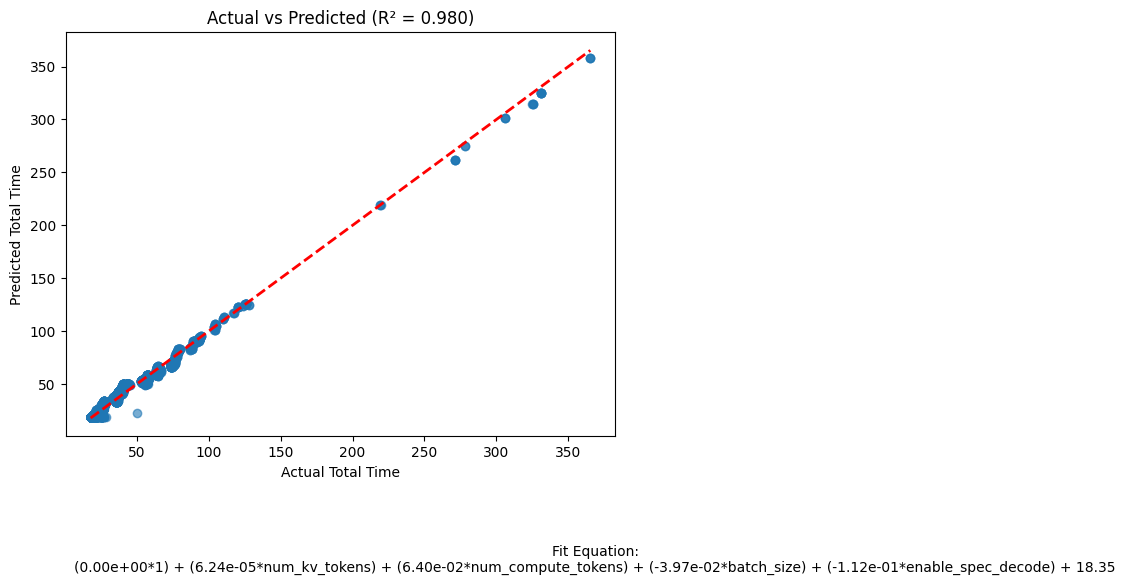

模型结构：
Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                ('regressor', LinearRegression())])

特征名称（标准化后的多项式特征）：
['1' 'num_kv_tokens' 'num_compute_tokens' 'batch_size'
 'enable_spec_decode']

R²分数 = 0.9802


In [12]:
from sklearn.metrics import r2_score
from joblib import dump

# model = LinearRegression(fit_intercept=True)
model = Pipeline([('poly', PolynomialFeatures(degree=1)),
                    #   ('scaler', StandardScaler()),
                      ('regressor', LinearRegression())])
model.fit(X_train, y_train)
dump(model, f'model_{y_label}.joblib')  # 保存模型


# 获取模型参数
coef = model.named_steps['regressor'].coef_
intercept = model.named_steps['regressor'].intercept_

# 生成特征名称（包含多项式项）
feature_names = model.named_steps['poly'].get_feature_names_out(
    ['num_kv_tokens', 'num_compute_tokens', 'batch_size', 'enable_spec_decode']
)

# 生成预测值
def score(X, y):
    y_pred = model.predict(X)
    r_squared = r2_score(y, y_pred)
    return y_pred, r_squared

print(model)
print(intercept)
print(coef)
y_test_pred, r_test_squared = score(X_test, y_test)
print(y_test_pred[:5])
print(y_test[:5])
print(X_test[:5])
print(f"\nTest R²分数 = {r_test_squared:.4f}")
    

# 3. 可视化结果
plt.figure(figsize=(12, 5))
y_pred, r_squared = score(X_train, y_train)
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Total Time')
plt.ylabel('Predicted Total Time')
plt.title(f'Actual vs Predicted (R² = {r_squared:.3f})')


plt.tight_layout()

# 显示拟合方程（简略版）
equation = "Fit Equation:\n"
equation += " + ".join([f"({c:.2e}*{name})" for c, name in zip(coef, feature_names)])
equation += f" + {intercept:.2f}"
plt.figtext(0.5, -0.15, equation, ha='center', fontsize=10, wrap=True)

plt.show()

# 打印模型信息
print("模型结构：")
print(model)
print("\n特征名称（标准化后的多项式特征）：")
print(feature_names)
print(f"\nR²分数 = {r_squared:.4f}")

In [26]:
goodput_data = []
with open('goodput') as f: 
    for line in f:
        entry = json.loads(line)
        goodput_data.append({
            "measured_goodput": entry['measured_goodput'],
            "num_kv_tokens": entry['num_kv_tokens'],
            "num_compute_tokens": entry['num_compute_tokens'],
            "batch_size": entry['batch_size'],
            "enable_spec_decode": entry['num_compute_tokens'] != entry['batch_size'],
            "predicted_goodput": entry['predicted_goodput'],
            "measured_time": entry['measured_time'],
            "prediced_time": entry['predicted_time'],
        })
df_goodput = pd.DataFrame(goodput_data)
df_goodput.head()

,measured_goodput,num_kv_tokens,num_compute_tokens,batch_size,enable_spec_decode,predicted_goodput,measured_time,prediced_time
0,37.165754,13,13,1,True,99.881216,26.906490,20.023785
1,36.181810,13,13,1,True,99.881216,27.638197,20.023785
2,37.259519,13,13,1,True,99.881216,26.838779,20.023785
3,36.310233,13,13,1,True,99.881216,27.540445,20.023785
4,52.274590,14,1,1,False,99.880876,19.129753,20.023853


<Axes: xlabel='num_compute_tokens', ylabel='measured_time'>

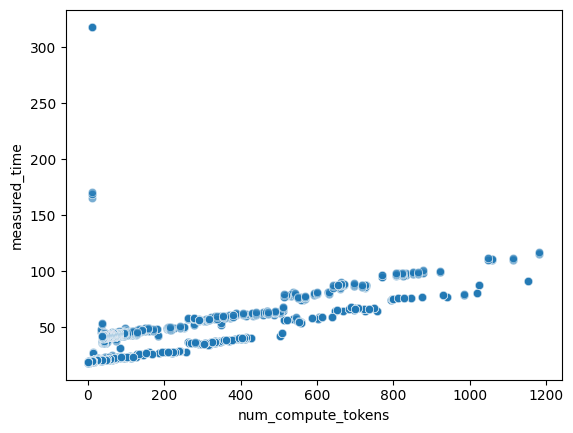

In [27]:
import seaborn as sns
sns.scatterplot(x=df_goodput['num_compute_tokens'], y=df_goodput['measured_time'], alpha=0.6)  # alpha控制点透明度

In [28]:
sns.scatterplot(x=df_goodput['measured_time'], y=df_goodput['predicted_time'], alpha=0.6)  # alpha控制点透明度

KeyError: 'predicted_time'